In [1]:
# Insert code here.
# Dependencies
import pandas as pd
import numpy as np
import requests
import json
from splinter import Browser
from bs4 import BeautifulSoup
import geopandas as gpd
from shapely.geometry import Point, Polygon
import re
import matplotlib.pyplot as plt
from citipy import citipy

In [2]:
# URL for the source of the data on Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_nuclear_power_stations'

In [18]:
# Use pandas to get the tables from the Wikipedia page and create a list
# of dictionaries
tables = pd.read_html(url,encoding='utf-8')
tables

[                                          0
 0  Map all coordinates using: OpenStreetMap
 1        Download coordinates as: KML · GPX,
     Power station # units[note 1] Net capacity[note 2](MWe)        Country  \
 0         Almaraz               2                      2017          Spain   
 1           Angra               2             1,884[note 3]         Brazil   
 2             ANO               2                      1839  United States   
 3            Ascó               2                      1992          Spain   
 4          Atucha               2                      1027      Argentina   
 ..            ...             ...                       ...            ...   
 146     Watts Bar               2                      2288  United States   
 147    Wolf Creek               1                      1160  United States   
 148      Wolseong      5[note 45]                      3835    South Korea   
 149     Yangjiang               6                      6000          Chin

In [4]:
# Isolate the second table from the list of dictionaries and make that dict a dataframe
df = tables[1]

In [5]:
# View the column names
df.columns

Index(['Power station', '# units[note 1]', 'Net capacity[note 2](MWe)',
       'Country', 'Location', 'Refs'],
      dtype='object')

In [6]:
# Change the column names
df.columns = ['Station', 'Units', 'Capacity_MWe', 'Country', 
              'Location', 'Refs']

In [7]:
# 
coordinates = df["Location"].str.split(" / ", n = 1, expand = True)

In [8]:
df["DMS_Lat_Long"]= coordinates[0] 
df["GP_Lat_Long"]= coordinates[1]

In [9]:
# Dropping old Location and Refs columns 
df.drop(columns =["Location","Refs","DMS_Lat_Long"], inplace = True) 

In [10]:
df.head()

,Station,Units,Capacity_MWe,Country,GP_Lat_Long
0,Almaraz,2,2017,Spain,﻿39.80806°N 5.69694°W
1,Angra,2,"1,884[note 3]",Brazil,﻿23.00833°S 44.47389°W
2,ANO,2,1839,United States,﻿35.31028°N 93.23139°W
3,Ascó,2,1992,Spain,﻿41.20000°N 0.56944°E
4,Atucha,2,1027,Argentina,﻿33.96750°S 59.20500°W


In [11]:
# Split the column of data GP_Lat_long that contains two coordinates into 
# two separate columns
DMS_coordinates = df["GP_Lat_Long"].str.split(" ", n = 1, expand = True)
df["GP_Lat"]= DMS_coordinates[0] 
df["GP_Long"]= DMS_coordinates[1]

In [12]:
# Create a function to transform the Latitude and Longitude points from the format
# 41.2000°S to -41.2000 for example 
def dms2dd(s):
    # example: s = """0°51'56.29"S"""
    coord, direction = re.split('°', s)
    #dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    coord = coord.replace(u'\ufeff','')
    coord = float(coord)
    if direction in ('S','W'):
        coord*= -1
    return coord

In [13]:
# Transform the Latitude and Longitude values to be either negative or positive
# Values for South and West are negative and North and East are positive
df['Latitude'] = df['GP_Lat'].apply(dms2dd)
df['Longitude'] = df['GP_Long'].apply(dms2dd)

In [14]:
# Remove the columns that are no longer necessary
df.drop(columns =["GP_Lat_Long","GP_Lat","GP_Long"], inplace = True) 

In [15]:
# Create a United States only slice of the dataframe
us = df[df["Country"] == "United States"]

In [16]:
# Create a geodata dataframe in order to be able to plot the points to a map of the United States
gdf = gpd.GeoDataFrame(
    us, geometry=gpd.points_from_xy(us.Longitude, us.Latitude))
gdf.head()

,Station,Units,Capacity_MWe,Country,Latitude,Longitude,geometry
2,ANO,2,1839,United States,35.31028,-93.23139,POINT (-93.23139 35.31028)
6,Beaver Valley,2,1738,United States,40.62333,-80.43056,POINT (-80.43056 40.62333)
10,Braidwood,2,2330,United States,41.24361,-88.22917,POINT (-88.22917 41.24361)
12,Browns Ferry,3,3300,United States,34.70389,-87.11861,POINT (-87.11861 34.70389)
14,Brunswick,2,1858,United States,33.95833,-78.01028,POINT (-78.01028 33.95833)


In [20]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

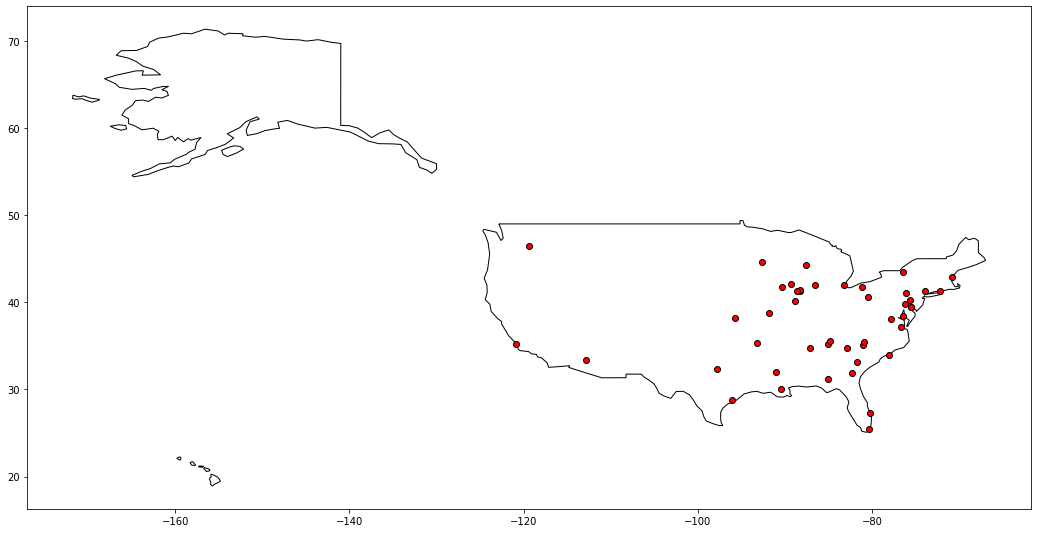

In [17]:
# Plot the nuclear facilities to a map of the United States
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
ax = world[world.name == "United States of America"].plot(
    color='white', edgecolor='black', figsize=(18,10))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red',edgecolors='black')

plt.show()